In [6]:
# Cell 1: install (if needed) and import libraries

# If torch/torchvision not installed, uncomment this:
# !pip install torch torchvision opencv-python scikit-learn matplotlib

import os
import glob
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:
!pip install scikit-learn


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.8 kB 393.8 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/60.8 kB 327.7 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 358.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.9 MB 1.3 MB/s eta 0:00:07
    --------------------------------------- 0.1/8.9 MB 1.3 MB/s eta 0:00:07
    --------------------------------------- 0.2/8.9 MB 919.0 kB/s eta 0:00:10
    --------------------------------------- 0.2/8.9 MB 985.7 kB/s eta 0:00:09
   - -------------------------------------- 0.2/8.9 MB 860.2 kB/s eta 0:00:11
   - --------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\albyb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ----- --------------------------------- 71.7/536.2 kB 2.0 MB/s eta 0:00:01
     -------- ----------------------------- 122.9/536.2 kB 1.4 MB/s eta 0:00:01
     ---------- --------------------------- 143.4/536.2 kB 1.2 MB/s eta 0:00:01
     ------------- ------------------------ 194.6/536.2 kB 1.1 MB/s eta 0:00:01
     --------------- -------------------- 225.3/536.2 kB 981.9 kB/s eta 0:00:01
     --------------- -------------------- 235.5/536.2 kB 962.7 kB/s eta 0:00:01
     ----------------- ------------------ 256.0/536.2 kB 923.9 kB/s eta 0:00:01
     ----------------- ------------------ 256.0/536.2 kB 923.9 kB/s eta 0:00:01
     ----------------- ------------------ 256.0/536.2 kB 923.9 kB/s eta 0:00:01
     ----------------- ------------------ 256.0/536.2 kB 923.9 kB/s eta 0:00:01
     ----------------- ------------------ 256.0/536.2 kB 923.9 kB/s et


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\albyb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import torch
torch.__version__


'2.9.1+cpu'

In [12]:
DATA_DIR = r"C:\Users\albyb\Downloads\SOCOFing\SOCOFing"

REAL_DIR = os.path.join(DATA_DIR, "real")
ALTERED_DIR = os.path.join(DATA_DIR, "altered")

real_files = glob.glob(os.path.join(REAL_DIR, "*.BMP"))
print("Total REAL images found:", len(real_files))

Total REAL images found: 6000


In [13]:
# Cell 3: extract person IDs from filenames and choose a subset to train on
import numpy as np
from collections import Counter

def get_person_id_from_filename(fname: str) -> str:
    base = os.path.basename(fname)
    return base.split("__")[0]

file_paths = np.array(real_files)                   # from your Cell 2
person_ids = np.array([get_person_id_from_filename(f) for f in file_paths])

unique_ids = sorted(list(set(person_ids)))
print("Unique IDs total:", len(unique_ids))
print("Sample IDs:", unique_ids[:10])

# For a quick experiment use a subset of IDs (change MAX_IDS later)
MAX_IDS = 50   # try 50 first, then increase (100, 200) when ready
chosen_ids = set(unique_ids[:MAX_IDS])

mask = np.array([pid in chosen_ids for pid in person_ids])
file_paths_small = file_paths[mask]
person_ids_small = person_ids[mask]

print("Subset images:", len(file_paths_small))
print("Unique IDs in subset:", len(set(person_ids_small)))


Unique IDs total: 600
Sample IDs: [np.str_('1'), np.str_('10'), np.str_('100'), np.str_('101'), np.str_('102'), np.str_('103'), np.str_('104'), np.str_('105'), np.str_('106'), np.str_('107')]
Subset images: 500
Unique IDs in subset: 50


In [14]:
# Cell 4: label encoding and stratified split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_int = label_encoder.fit_transform(person_ids_small)

X_train, X_val, y_train, y_val = train_test_split(
    file_paths_small, labels_int, test_size=0.2, stratify=labels_int, random_state=42
)

print("Train size:", len(X_train), "Val size:", len(X_val))


Train size: 400 Val size: 100


In [15]:
import random
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

IMG_SIZE = 128

class FingerprintDataset(Dataset):
    def __init__(self, file_paths, labels, img_size=IMG_SIZE, augment=False):
        self.file_paths = list(file_paths)
        self.labels = list(labels)
        self.img_size = img_size
        self.augment = augment
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def _preprocess(self, img):
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = cv2.GaussianBlur(img, (5,5), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        return img

    def _augment(self, img):
        angle = random.uniform(-15, 15)
        h, w = img.shape
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
        return img

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError("Could not read image: " + path)
        img = self._preprocess(img)
        if self.augment:
            img = self._augment(img)
        img = np.expand_dims(img, -1)
        img_t = self.to_tensor(img)
        return img_t, torch.tensor(label, dtype=torch.long)


In [16]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataset = FingerprintDataset(X_train, y_train, img_size=IMG_SIZE, augment=True)
val_dataset   = FingerprintDataset(X_val, y_val, img_size=IMG_SIZE, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Batches ~ train:", len(train_loader), "val:", len(val_loader))


Batches ~ train: 13 val: 4


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleFingerprintCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleFingerprintCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # After 3 poolings: 128×16×16 → flatten = 32768
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [19]:
num_classes = len(label_encoder.classes_)
model = SimpleFingerprintCNN(num_classes=num_classes).to(device)
print(model)


SimpleFingerprintCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
)


In [20]:
# Cell: loss function, optimizer and accuracy helper

import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total


In [21]:
# Cell: training loop

EPOCHS = 8  # you can increase later

for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        c, t = accuracy_from_logits(outputs, labels)
        train_correct += c
        train_total += t

    train_loss /= train_total
    train_acc = train_correct / train_total

    # ---- validation ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            c, t = accuracy_from_logits(outputs, labels)
            val_correct += c
            val_total += t

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.3f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.3f}"
    )


Epoch 01/8 | Train loss: 10.7209, acc: 0.022 | Val loss: 3.9557, acc: 0.030
Epoch 02/8 | Train loss: 3.9227, acc: 0.025 | Val loss: 3.8954, acc: 0.040
Epoch 03/8 | Train loss: 3.9048, acc: 0.022 | Val loss: 3.9011, acc: 0.020
Epoch 04/8 | Train loss: 3.9074, acc: 0.020 | Val loss: 3.8901, acc: 0.030
Epoch 05/8 | Train loss: 3.8907, acc: 0.035 | Val loss: 3.8733, acc: 0.030
Epoch 06/8 | Train loss: 3.8929, acc: 0.028 | Val loss: 3.8897, acc: 0.040
Epoch 07/8 | Train loss: 3.8749, acc: 0.030 | Val loss: 3.8750, acc: 0.030
Epoch 08/8 | Train loss: 3.8502, acc: 0.028 | Val loss: 3.8659, acc: 0.040


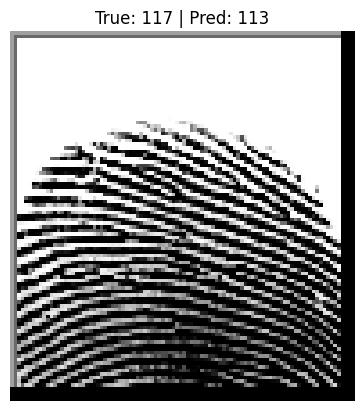

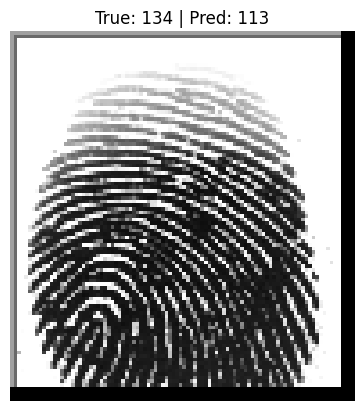

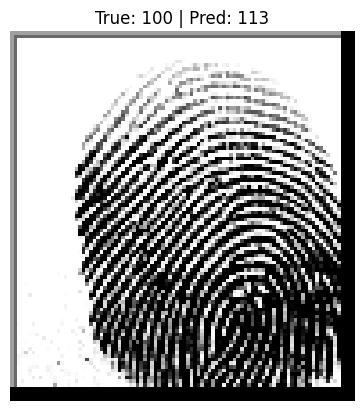

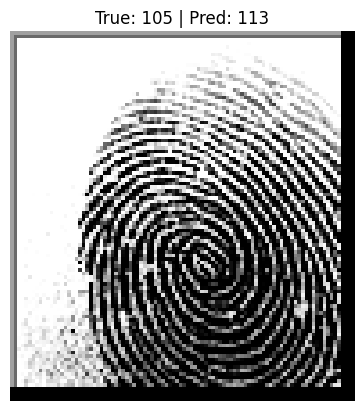

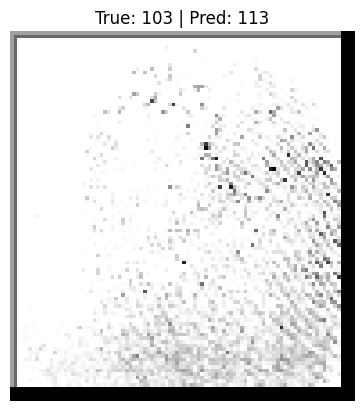

In [22]:
# Cell: test a few validation images

import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms

model.eval()

indices = np.random.choice(len(X_val), size=5, replace=False)

for idx in indices:
    path = X_val[idx]
    true_label_int = y_val[idx]
    true_id = label_encoder.inverse_transform([true_label_int])[0]

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_pp = clahe.apply(img_resized)

    img_pp = np.expand_dims(img_pp, axis=-1)
    t = transforms.ToTensor()(img_pp)
    t = transforms.Normalize(mean=[0.5], std=[0.5])(t)
    t = t.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(t)
        pred_int = torch.argmax(logits, dim=1).item()
        pred_id = label_encoder.inverse_transform([pred_int])[0]

    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_id} | Pred: {pred_id}")
    plt.axis("off")
    plt.show()


In [23]:
import pickle

torch.save(model.state_dict(), "fingerprint_cnn.pth")
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Model and label encoder saved.")


Model and label encoder saved.


In [24]:
# Inference interface: imports & device

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [25]:
# SimpleFingerprintCNN definition (must match training time)

IMG_SIZE = 128  # same as you used for training

class SimpleFingerprintCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleFingerprintCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # 3 poolings → IMG_SIZE / 8 (for 128 → 16)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [26]:
# Load trained model weights and label encoder

MODEL_PATH = "fingerprint_cnn.pth"      # change if saved elsewhere
LE_PATH    = "label_encoder.pkl"        # change if saved elsewhere

# load label encoder
with open(LE_PATH, "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)
print("Classes in encoder:", num_classes)

# build model and load weights
model = SimpleFingerprintCNN(num_classes=num_classes).to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Model and label encoder loaded.")


Classes in encoder: 50
Model and label encoder loaded.


In [27]:
# Preprocessing + prediction helper

def preprocess_image(path, img_size=IMG_SIZE):
    """Load a fingerprint image and preprocess it like training."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image at: {path}")

    # resize
    img = cv2.resize(img, (img_size, img_size))
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    # add channel dim
    img = np.expand_dims(img, axis=-1)  # (H,W,1)

    # to tensor + normalize (same as training)
    t = transforms.ToTensor()(img)          # (1,H,W), 0–1
    t = transforms.Normalize([0.5], [0.5])(t)
    t = t.unsqueeze(0)                      # (1,1,H,W) batch
    return img[...,0], t  # return processed image for viewing + tensor


def predict_fingerprint(image_path: str):
    """Predict person ID for given fingerprint image path."""
    # preprocess
    img_vis, tensor = preprocess_image(image_path)
    tensor = tensor.to(device)

    # forward pass
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = int(torch.argmax(probs, dim=1).item())
        confidence = float(torch.max(probs).item())

    # decode label
    pred_id = label_encoder.inverse_transform([pred_idx])[0]

    # show image with title
    plt.imshow(img_vis, cmap="gray")
    plt.title(f"Predicted ID: {pred_id}  (conf: {confidence:.2f})")
    plt.axis("off")
    plt.show()

    return pred_id, confidence


In [29]:
import os

test_path = r"C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Altered\Altered-Medium\9__M_Left_index_finger.BMP"  # put EXACT path you typed

print("Exists:", os.path.exists(test_path))


Exists: False


In [30]:
import os

test_path = r"C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Altered\Altered-Hard\9__M_Left_little_finger_CR.BMP"

print(os.path.exists(test_path))


True


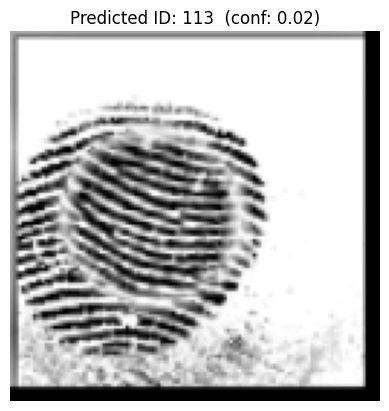

Predicted ID: 113 | Confidence: 0.021


In [31]:
pred_id, conf = predict_fingerprint(test_path)
print("Predicted ID:", pred_id, "| Confidence:", round(conf, 3))


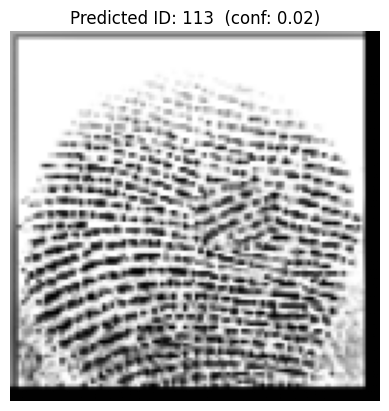

Predicted ID: 113 | Confidence: 0.021


In [33]:
test_path = r"C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Altered\Altered-Easy\95__M_Right_thumb_finger_CR.BMP"   # ← change this

pred_id, conf = predict_fingerprint(test_path)
print("Predicted ID:", pred_id, "| Confidence:", round(conf, 3))



Testing: C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Altered\Altered-Easy\96__M_Left_middle_finger_Zcut.BMP


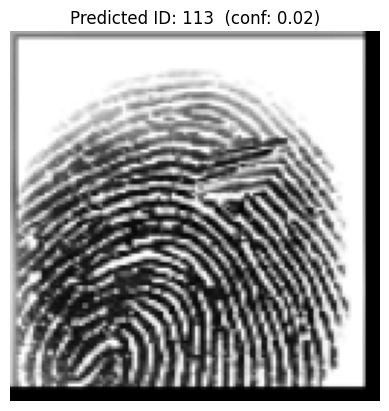

Predicted: 113 | Confidence: 0.021

Testing: C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Altered\Altered-Medium\99__M_Left_ring_finger_Obl.BMP


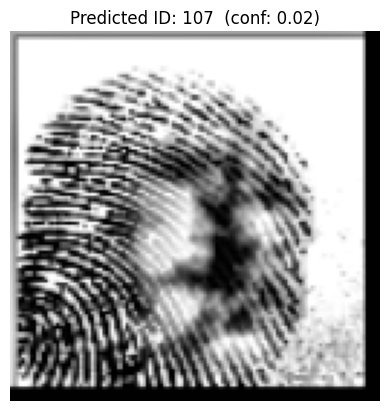

Predicted: 107 | Confidence: 0.022

Testing: C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Real\77__M_Left_ring_finger.BMP


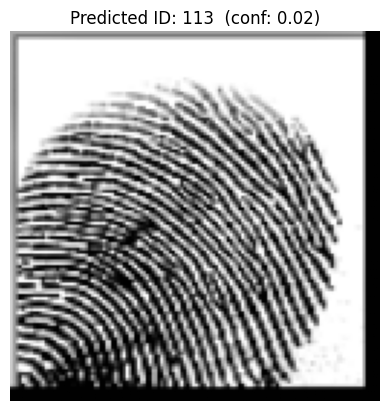

Predicted: 113 | Confidence: 0.021


In [34]:
test_images = [
    r"C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Altered\Altered-Easy\96__M_Left_middle_finger_Zcut.BMP",
    r"C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Altered\Altered-Medium\99__M_Left_ring_finger_Obl.BMP",
    r"C:\Users\albyb\Downloads\SOCOFing\SOCOFing\Real\77__M_Left_ring_finger.BMP"
]

for path in test_images:
    print("\nTesting:", path)
    pred_id, conf = predict_fingerprint(path)
    print("Predicted:", pred_id, "| Confidence:", round(conf, 3))


In [2]:
from tkinter import Tk, Button, Label, filedialog, StringVar
import tkinter as tk
from PIL import Image, ImageTk


In [7]:
!pip install flask


   ---------------------------------------- 0.0/103.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/103.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/103.3 kB ? eta -:--:--
   --- ------------------------------------ 10.2/103.3 kB ? eta -:--:--
   --- ------------------------------------ 10.2/103.3 kB ? eta -:--:--
   ----------- --------------------------- 30.7/103.3 kB 187.9 kB/s eta 0:00:01
   ----------- --------------------------- 30.7/103.3 kB 187.9 kB/s eta 0:00:01
   ----------------------- --------------- 61.4/103.3 kB 252.2 kB/s eta 0:00:01
   --------------------------- ----------- 71.7/103.3 kB 262.6 kB/s eta 0:00:01
   --------------------------- ----------- 71.7/103.3 kB 262.6 kB/s eta 0:00:01
   -------------------------------------  102.4/103.3 kB 268.7 kB/s eta 0:00:01
   -------------------------------------- 103.3/103.3 kB 259.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/108.3 kB ? eta -:--:--
   --- -----


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\albyb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
from flask import Flask, request, render_template_string, send_file


In [18]:
import os

search_root = r"C:\Users\albyb"

for root, dirs, files in os.walk(search_root):
    if "label_encoder.pkl" in files:
        print("FOUND:", os.path.join(root, "label_encoder.pkl"))


FOUND: C:\Users\albyb\OneDrive\Desktop\computer vision\finger print 1\label_encoder.pkl


In [19]:
import os

search_root = r"C:\Users\albyb\Downloads\SOCOFing"

for root, dirs, files in os.walk(search_root):
    if "label_encoder.pkl" in files:
        print("FOUND:", os.path.join(root, "label_encoder.pkl"))


In [20]:
import os

search_root = r"C:\Users\albyb\OneDrive\Desktop"

for root, dirs, files in os.walk(search_root):
    if "label_encoder.pkl" in files:
        print("FOUND:", os.path.join(root, "label_encoder.pkl"))


FOUND: C:\Users\albyb\OneDrive\Desktop\computer vision\finger print 1\label_encoder.pkl


In [21]:
ENCODER_PATH = r"C:\Users\albyb\OneDrive\Desktop\fingerprint_project\label_encoder.pkl"
